In [1]:
import pandas as pd
import numpy as np

### Train vs test error : increasing error
* underfit : 1
* sweet spot : 2
* overfit : 5,9
  
<img src='data/11.png' width='800px' height='500px'>
<br>
<img src='data/12.png' width='800px' height='500px'>
<br>
<img src='data/13.png' width='800px' height='500px'>


### Overfiting vs underfitting

In [55]:
import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100


regressor = DecisionTreeRegressor(random_state=0)


cv= ShuffleSplit(n_splits=30, test_size=0.2)
cv_result = cross_validate(regressor, data, target, cv=cv, scoring='neg_mean_absolute_error', return_train_score= True, n_jobs= 2)

cv_result = pd.DataFrame(cv_result)

(30, 4)

In [6]:
scores = pd.DataFrame()

scores[['train error', 'test error']] = -cv_result[['train_score', 'test_score']]

<AxesSubplot:ylabel='Frequency'>

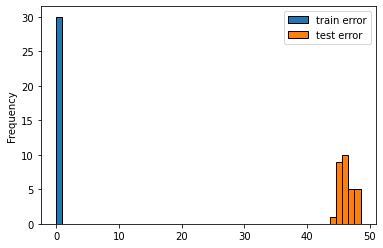

In [7]:
import matplotlib.pyplot as plt

scores.plot.hist(bins=50,edgecolor='black')

### Train error
we observe a small training error (actually zero), meaning that the model is not under-fitting: it is flexible enough to capture any variations present in the training set.

### Test error
However the significantly larger testing error tells us that the model is over-fitting: the model has memorized many variations of the training set that could be considered “noisy” because they do not generalize to help us make good prediction on the test set.

### Validation Curve

In [8]:
from sklearn.model_selection import validation_curve

max_depth = [1,5,10,15,20,25]

train_scores, test_scores = validation_curve(regressor,data,target, param_name='max_depth', param_range=max_depth, cv=cv, scoring='neg_mean_absolute_error', n_jobs=2)

train_errors, test_errors = -train_scores, -test_scores

Text(0.5, 0, 'maximum_depth')

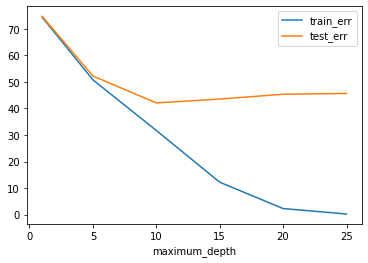

In [10]:
plt.plot(max_depth,train_errors.mean(axis=1), label='train_err')
plt.plot(max_depth,test_errors.mean(axis=1), label='test_err')
plt.legend()
plt.xlabel('maximum_depth')

**max_depth < 10**

For max_depth < 10, the decision tree underfits. The training error and therefore the testing error are both high. The model is too constrained and cannot capture much of the variability of the target variable.

**max_depth = 10**

The region around max_depth = 10 corresponds to the parameter for which the decision tree generalizes the best. It is flexible enough to capture a fraction of the variability of the target that generalizes, while not memorizing all of the noise in the target.

**max_depth > 10**

For max_depth > 10, the decision tree overfits. The training error becomes very small, while the testing error increases. In this region, the models create decisions specifically for noisy samples harming its ability to generalize to test data.

Text(0.5, 0, 'maximum_depth')

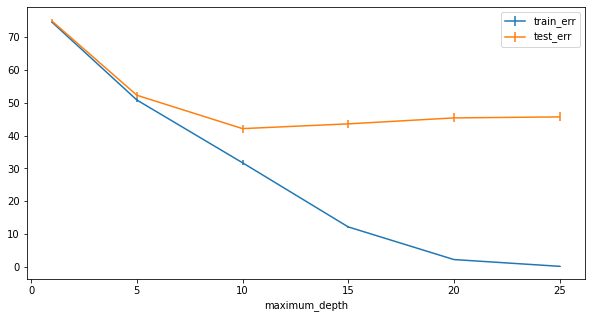

In [13]:
plt.figure(figsize=(10,5))
plt.errorbar(max_depth,train_errors.mean(axis=1), label='train_err', yerr=train_errors.std(axis=1))
plt.errorbar(max_depth,test_errors.mean(axis=1), label='test_err', yerr=test_errors.std(axis=1))
plt.legend()
plt.xlabel('maximum_depth')

### Effect of the samplesize in cross-validation

it is also important to understand how the different errors are influenced by the number of samples available.

### Learning curve

To understand the impact of the number of samples available for training on the generalization performance of a predictive model, it is possible to synthetically reduce the number of samples used to train the predictive model and check the training and testing errors.

Therefore, we can vary the number of samples in the training set and repeat the experiment. The training and testing scores can be plotted similarly to the validation curve, but instead of varying a hyperparameter, we vary the number of training samples. This curve is called the learning curve.

In [16]:
train_sizes = np.linspace(0.1,1, num=5, endpoint= True)
train_sizes

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [17]:
from sklearn.model_selection import learning_curve

results =learning_curve(regressor, data, target, train_sizes=train_sizes, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)

train_size, train_scores, test_scores = results[:3]

train_errors, test_errors = -train_scores, -test_scores

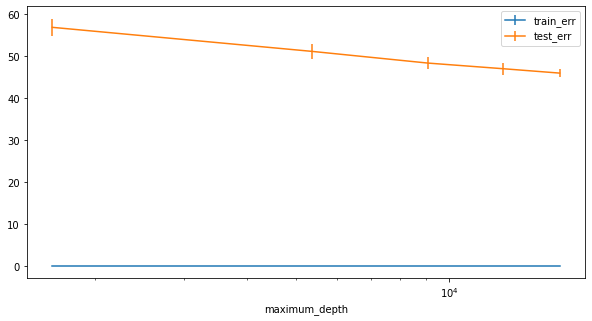

In [18]:
plt.figure(figsize=(10,5))
plt.errorbar(train_size,train_errors.mean(axis=1), label='train_err', yerr=train_errors.std(axis=1))
plt.errorbar(train_size,test_errors.mean(axis=1), label='test_err', yerr=test_errors.std(axis=1))
plt.legend()
plt.xlabel('maximum_depth')
plt.xscale('log')

### Bayes error rate
sample을 추가해도 에러가 감소하지 않는 수준 -> 이때는 좀 더 복잡한 모델을 생성해 추가된 sample이 test_error를 줄일 수 있도록 해야함.

If we achieve a plateau and adding new samples in the training set does not reduce the testing error, we might have reach the Bayes error rate using the available model. Using a more complex model might be the only possibility to reduce the testing error further.



### Exercise

In [63]:
blood_df = pd.read_csv('data/blood_transfusion.csv')
data = blood_df.drop(columns='Class')
target = blood_df['Class']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
dtypes: int64(4)
memory usage: 23.5 KB


In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = Pipeline([('preprocessor', StandardScaler()), ('svc',SVC(kernel='rbf'))])


In [65]:
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(random_state=0)
# cv_result = cross_validate(model, data, target, cv=cv)

In [66]:
from sklearn.model_selection import validation_curve
gamma = np.logspace(-3,2,num=30)
# model.set_params(Classifier__gamma = gamma)
cv_result = validation_curve(model,data,target, cv=cv, scoring='accuracy',param_name = 'svc__gamma', param_range = gamma)

In [67]:
train_score , test_score = cv_result[0], cv_result[1]

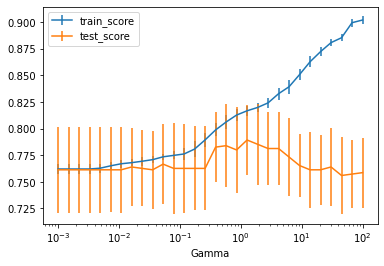

In [71]:
# plt.figure(figsize=(10,4))
plt.errorbar(gamma,train_score.mean(axis=1),yerr=train_score.std(axis=1), label='train_score')
plt.errorbar(gamma,test_score.mean(axis=1), yerr=test_score.std(axis=1), label='test_score')
plt.xlabel('Gamma')
plt.xscale('log')
plt.legend()

In [73]:
from sklearn.model_selection import learning_curve
size =np.linspace(0.1,1, num=10)
cv_learning = learning_curve(model, data, target, train_sizes=size, cv=cv, scoring='accuracy')

In [74]:
size, train_score, test_score = cv_learning

Text(0.5, 0, 'number of samples')

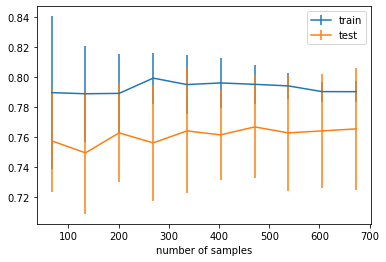

In [75]:
plt.errorbar(size,train_score.mean(axis=1), yerr=train_score.std(axis=1) ,label='train')
plt.errorbar(size,test_score.mean(axis=1), yerr=test_score.std(axis=1) ,label='test')
plt.legend()
plt.xlabel('number of samples')

In [76]:
target.value_counts(normalize=True)

not donated    0.762032
donated        0.237968
Name: Class, dtype: float64

We observe that adding new samples to the training dataset does not seem to improve the training and testing scores. In particular, the testing score oscillates around 76% accuracy. Indeed, ~76% of the samples belong to the class "not donated"``. Notice then that a classifier that always predicts the “not donated”`` class would achieve an accuracy of 76% without using any information from the data itself. This can mean that our small pipeline is not able to use the input features to improve upon that simplistic baseline, and increasing the training set size does not help either.

It could be the case that the input features are fundamentally not very informative and the classification problem is fundamentally impossible to solve to a high accuracy. But it could also be the case that our choice of using the default hyperparameter value of the SVC class was a bad idea, or that the choice of the SVC class is itself sub-optimal.

1. b) train error is low but test error is high
2. a) both the train and test errors are high
3. a) a wider difference between train and test errors / b) a reduction in the difference between train and test errors
4. a) a wider difference between train and test errors / d) a decrease in the train error
5. c) get lower training error than lower degree polynomial models / d) are more likely to overfit than lower degree polynomial models.
6. b) False

### Bias versus Variance
* bias : 영점조절이 안된 경우 
* variance : 실력이 오락가락하는 경우

<br>
<img src='data/14.png' width ='800px' height = '500px'>
<br>
<img src='data/15.png' width ='800px' height = '500px'>

### Wrap up

Overfitting is caused by the limited size of the training set, the noise in the data, and the high flexibility of common machine learning models.

Underfitting happens when the learnt prediction functions suffer from systematic errors. This can be caused by a choice of model family and parameters, which leads to a lack of flexibility to capture the repeatable structure of the true data generating process.

For a fixed training set, the objective is to minimize the test error by adjusting the model family and its parameters to find the best trade-off between overfitting for underfitting.

For a given choice of model family and parameters, increasing the training set size will decrease overfitting but can also cause an increase of underfitting.

The test error of a model that is neither overfitting nor underfitting can still be high if the variations of the target variable cannot be fully determined by the input features. This irreducible error is caused by what we sometimes call label noise. In practice, this often happens when we do not have access to important features for one reason or another